
## Predictive modeling of customer bookings

This Jupyter notebook includes code to create predictive modeling of customer bookings of british airways. We will use various packages for data manipulation, feature engineering and machine learning. For the predictive modeling I chose the Random Forest,  It's a process that operates among multiple decision trees to get the optimum result by choosing the majority among them as the best value.


### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import numpy as nm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/kaggle/input/customer-booking/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [7]:
feature_names=df.columns

In [8]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [9]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0


**Now we create two different dataset one for features or independent variables which is x and one for our target column or dependent variable which is y.**

In [10]:
x= pd.DataFrame(df.iloc[:, [0,3,4,5,6,9,10,11,12] ].values)  
y= df.iloc[:, -1].values

we rename the feature dataframe columns because in future it will help us to understand which feature in more important for the prediction.

In [11]:
x.rename(columns = {0:'num_passengers', 1:'purchase_lead',
                              2:'length_of_stay',3:'flight_hour',4:'flight_day',5:'wants_extra_baggage',6:'wants_preferred_seat',7:'wants_in_flight_meals',8:'flight_duration'}, inplace = True)

In [12]:
x

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
0,2.0,262.0,19.0,7.0,6.0,1.0,0.0,0.0,5.52
1,1.0,112.0,20.0,3.0,6.0,0.0,0.0,0.0,5.52
2,2.0,243.0,22.0,17.0,3.0,1.0,1.0,0.0,5.52
3,1.0,96.0,31.0,4.0,6.0,0.0,0.0,1.0,5.52
4,2.0,68.0,22.0,15.0,3.0,1.0,0.0,1.0,5.52
...,...,...,...,...,...,...,...,...,...
49995,2.0,27.0,6.0,9.0,6.0,1.0,0.0,1.0,5.62
49996,1.0,111.0,6.0,4.0,7.0,0.0,0.0,0.0,5.62
49997,1.0,24.0,6.0,22.0,6.0,0.0,0.0,1.0,5.62
49998,1.0,15.0,6.0,11.0,1.0,1.0,0.0,1.0,5.62


In [13]:
x.shape
y.shape

(50000,)

Importing train test split from scikit learn to create our tarining and testing set

In [14]:
from sklearn.model_selection import train_test_split  
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.25, random_state=0)  

Now we will scale our dataset it helps with any biasness present for any values.
For that we import StandardScaler from scikit learn.

In [15]:
from sklearn.preprocessing import StandardScaler    
st_x= StandardScaler()    
x_train= st_x.fit_transform(x_train)    
x_test= st_x.transform(x_test) 

In [16]:
from sklearn.ensemble import RandomForestClassifier  
classifier= RandomForestClassifier(n_estimators= 20, criterion="entropy")  
classifier.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=20)

**After scaling we can apply our random forest to the train dataset and for that we import RandomForestClassifier from scikit learn**

Now that Random forest is applied and stored in classifier we can check our prediction score, In this case the score in 0.99 which is very good model.

In [17]:
classifier.score(x_train, y_train)

0.99232

In [18]:
classifier.feature_importances_

array([0.06036707, 0.29477909, 0.16518361, 0.19470315, 0.11863672,
       0.01441902, 0.01584275, 0.02491731, 0.11115127])

Now we can calculate and plot the feature importance of the dataframe, we can do the random forest agian with omiting the less important features that usually does improve prediction but as we got 0.99 we can ignore that part.

Text(0.5, 0, 'Feature Importance')

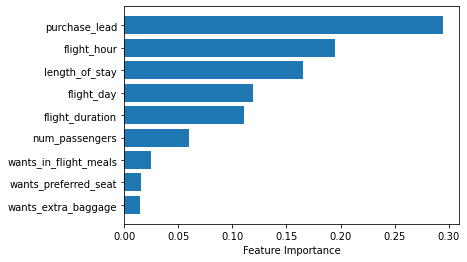

In [19]:
sort = classifier.feature_importances_.argsort()
plt.barh(x.columns[sort], classifier.feature_importances_[sort])
plt.xlabel("Feature Importance")

In [20]:
df
#3,4,5,12

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0


In [21]:
y_pred= classifier.predict(x_test)

In [22]:

errors = abs(y_pred - y_test)
print('Mean Absolute Error:', round(nm.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.16 degrees.


In [23]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.8428


Calculation for error calculation  and accuracy score which we can import from scikit learn matrics

In [24]:
from sklearn.metrics import confusion_matrix  
cm= confusion_matrix(y_test, y_pred) 


Creating confusion matrix and plotting it.

Text(69.0, 0.5, 'Truth')

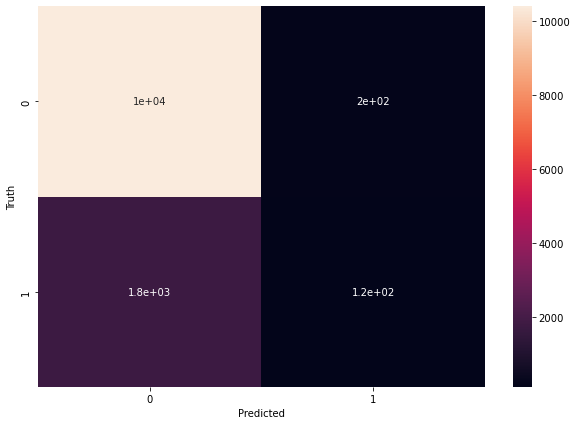

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot= True)
plt.xlabel('Predicted')
plt.ylabel('Truth')